In [1]:
using FileIO
using PyPlot
using ColorSchemes
using StatsBase, Statistics
GS = matplotlib.gridspec
ticker = matplotlib.ticker
patches = matplotlib.patches

path = "/network/aopp/chaos/pred/kloewer/esowc/analysis/";

In [2]:
BI = load(joinpath(path,"bitinformation_25members.jld2"),"BI")

bitvec = collect(1:32)
timevec1 = collect(0:90) / 24       # in days, hourly
timevec2 = collect(93:3:144) / 24   # 3-hourly
timevec3 = collect(150:6:360) / 24; # 6-hourly
timevec = vcat(timevec1,timevec2,timevec3);

BInan = copy(BI)
BInan[iszero.(BI)] .= NaN;

Xzstd,Xzfp = load(joinpath(path,"ensemble_compression_25members_s5-8.jld2"),"Xzstd","Xzfp");

In [3]:
# via preserving p amount of information
p = 99
ntsteps = size(BI)[1]
bits_with_information = [argmax(cumsum(BI[t,:]) .> (p/100)*sum(BI[t,:])) for t in 1:ntsteps];

# via insignificantly different from 0
# pmax = maximum(BI[:,22:end])
# argmin(diff(BI .> pmax,dims=2),dims=2)
# bits_with_information = [argmin(diff(BI[t,:] .> pmax)) for t in 1:ntsteps];

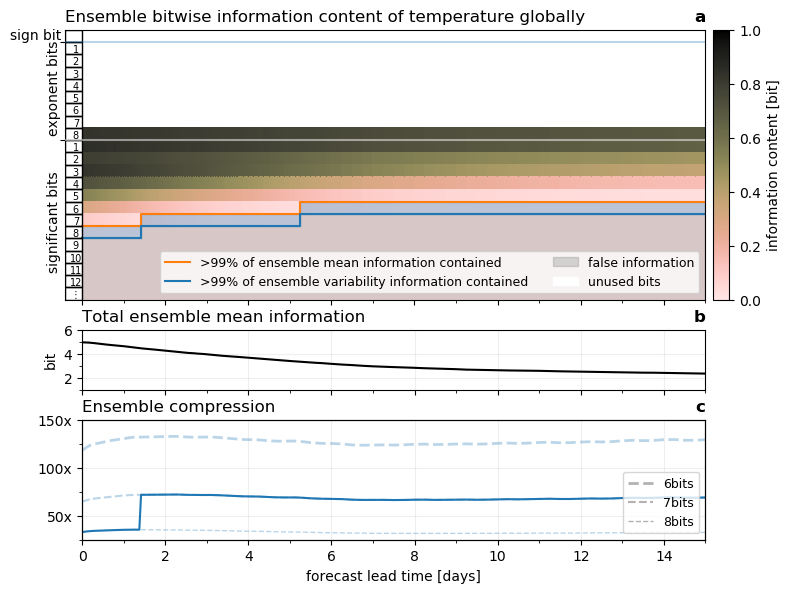

In [35]:
## plotting
fig = figure(figsize=(8,6))

ax1 = fig.add_axes([0.1,0.5,.8,.45])
shortx0 = 0.021
ax2 = fig.add_axes([0.1+shortx0,0.35,.8-shortx0,.1])
ax3 = fig.add_axes([0.1+shortx0,0.1,.8-shortx0,.2])

pos = ax1.get_position()
cax = fig.add_axes([pos.x1+0.01,pos.y0,0.02,pos.y1-pos.y0])
ax1.invert_yaxis()

# information
cmap = ColorMap(ColorSchemes.turku.colors).reversed()
cmap_array = cmap(0:1/100000:1)
cmap_array[1,:] = [1,1,1,1]

pcm = ax1.pcolormesh(timevec,bitvec .- 0.5,BInan',vmin=0,vmax=1;cmap)
cbar = colorbar(pcm,cax=cax,orientation="vertical")
cbar.set_label("information content [bit]")

ax1.axhline(1.5,alpha=.3,lw=1.5,zorder=10)
ax1.axhline(9.5,alpha=.5,lw=1.5,color="w",zorder=10)

# total information
ax2.plot(timevec,sum(BI,dims=2),"k")
ax1.fill_between(timevec,32*ones(length(timevec)),1.5 .+ bits_with_information,
                color="grey",alpha=0.3,step="post",label="false information")
ax1.fill_between(timevec,1.5 .+ bits_with_information,0.5 .+ bits_with_information,
                color="C0",alpha=0.3,step="post")

ax1.plot(timevec,0.5 .+ bits_with_information,"C1",ds="steps-post",label=">$p% of ensemble mean information contained")
ax1.plot(timevec,1.5 .+ bits_with_information,"C0",ds="steps-post",label=">$p% of ensemble variability information contained")


# only for legend
ax1.fill_between([0,0],[0,0],color="w",label="unused bits")

# show bits
ax1.add_patch(patches.Rectangle((-.4,.5),.4,1,edgecolor="k",fill=false))
for y in bitvec[2:22]
    ax1.add_patch(patches.Rectangle((-.4,y-.5),.4,1,edgecolor="k",fill=false,zorder=10))
    
    if y < 10
        bit_string = string(y-1)
    elseif y < 22
        bit_string = string(y-9)
    else
        bit_string = "⋮"
    end
    
    ax1.text(-.15,y+.1,bit_string,fontsize=7,ha="center",va="center")
end

# compression factors
bits_with_information[bits_with_information .== 14] .= 15

Xzfp_opt = Xzfp[:,1]
Xzstd_opt = Xzstd[:,1]
for (i,bits) in enumerate([7,6,5])
    w = (bits_with_information .- 9) .== bits
#     Xzfp_opt[w] = Xzfp[w,i+1]
    Xzstd_opt[w] = Xzstd[w,i]
end

ax3.plot(timevec,Xzstd_opt,"C0",label="Round+lossless")
# ax3.plot(timevec,Xzfp_opt,"teal",label="Zfp compression")

ax3r = ax3.twinx()
labls = ["6bits","7bits","8bits"]
for (i,lw) in enumerate([2,1.5,1])
#     ax3.plot(timevec,Xzfp[:,5-i],"teal",ls="--",lw=lw,alpha=0.3)
    ax3.plot(timevec,Xzstd[:,4-i],"C0",ls="--",lw=lw,alpha=0.3)
    ax3r.plot([0,0],[0,0],"grey",ls="--",lw=lw,alpha=0.6,label=labls[i])
end

ax1.set_title("Ensemble bitwise information content of temperature globally",loc="left")
ax2.set_title("Total ensemble mean information",loc="left")
ax3.set_title("Ensemble compression",loc="left")

ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax3.set_title("c",loc="right",fontweight="bold")
ax1.legend(loc=4,ncol=2,fontsize=9)
# ax3.legend(loc=2,ncol=1,fontsize=8)
ax3r.legend(loc=4,ncol=1,fontsize=9)
ax3r.set_yticks([])

ax1.set_xlim(-.4,360/24)
ax2.set_xlim(0,360/24)
ax3.set_xlim(0,360/24)

ax1.set_ylim(22.5,0.5)
ax2.set_ylim(1,6)
ymax = 150
ax3.set_ylim(25,ymax)

ax1.set_yticks([1.5,9.5])
ax2.set_yticks(2:2:6)
ax2.set_yticks(1:6,minor=true)
ax3.set_yticks([50,100,150])
ax3.set_yticks(25:25:ymax,minor=true)
ax2.set_ylabel("bit")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_xticks(1:15,minor=true)
ax2.set_xticks(1:15,minor=true)
ax3.set_xticks(1:15,minor=true)
ax3.set_xlabel("forecast lead time [days]")

ax2.grid(alpha=.2)
ax3.grid(alpha=.2)

ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dx"))

ax1.text(-0.5,1.3,"sign bit",ha="right")
ax1.text(-0.5,8.9,"exponent bits",rotation=90,ha="right")
ax1.text(-0.5,20,"significant bits",rotation=90,ha="right")
savefig("../plots/ensemble_information2.png")

In [36]:
1 ./ mean(1 ./ Xzstd_opt)

56.429667211384604

In [37]:
bits_with_information

145-element Array{Int64,1}:
 16
 16
 16
 16
 16
 16
 16
 16
 16
 16
 16
 16
 16
  ⋮
 15
 15
 15
 15
 15
 15
 15
 15
 15
 15
 15
 15